# Predicting realized volatility using Google Trends

## Import packages

In [1]:
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [2]:
register_matplotlib_converters()

## Define `indices`, `in_sample` and `out_of_sample`

In [3]:
indices = ["FTSE 100", "CAC 40", "DJIA", "DAX"]

In [4]:
in_sample = slice("2006-07-01", "2008-06-30")
out_of_sample = slice("2008-07-01", "2011-06-30")

## Read and plot the data

In [5]:
svrv = pd.read_csv("svrv.csv", index_col=[0, 1], parse_dates=True)

In [6]:
svrv.head()

sv        rv
datetime   index                       
2006-05-01 DJIA      0.501688  0.006356
2006-05-02 CAC 40    0.707594  0.005779
           DAX       0.683871  0.004733
           DJIA      0.712925  0.004254
           FTSE 100  0.721744  0.006403

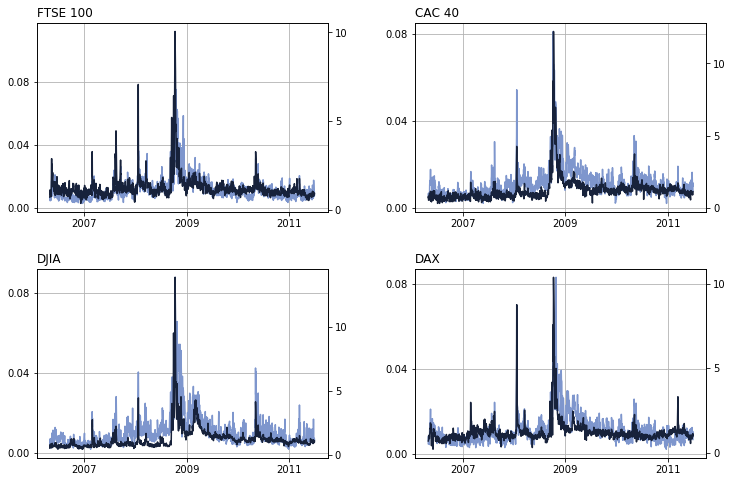

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for i, index in enumerate(indices):
    xs = svrv.xs(index, level=1)
    ax1 = axes[i]
    ax1.grid()
    ax1.plot(xs.index, xs["rv"], c="#7e96cd")
    ax1.set_title(index, loc="left")
    ax1.yaxis.set_major_locator(plticker.MultipleLocator(base=0.04))
    ax2 = ax1.twinx()
    ax2.plot(xs.index, xs["sv"], c="#17223B")
    ax2.set_xticks(["2007", "2009", "2011"])
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax2.yaxis.set_major_locator(plticker.MultipleLocator(base=5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Prepare data for modelling 

In [8]:
svrv["c"] = 1

In [9]:
svrv[["s", "v"]] = np.log(svrv[["sv", "rv"]])
svrv[["s_d", "v_d"]] = svrv[["s", "v"]].groupby(level=1).shift()
svrv["v_w"] = svrv.groupby(level=1)["v_d"].apply(lambda x: x.rolling(5).mean())
svrv["v_m"] = svrv.groupby(level=1)["v_d"].apply(lambda x: x.rolling(22).mean())

In [10]:
cols = ["c", "v_d", "v_w", "v_m", "s_d", "v"]
svrv = svrv.loc[pd.IndexSlice[in_sample.start:, :], cols]

In [11]:
svrv.head()

c       v_d       v_w       v_m       s_d         v
datetime   index                                                        
2006-07-03 CAC 40    1 -4.800212 -4.969261 -4.660490 -0.125407 -5.284510
           DAX       1 -4.545621 -4.756239 -4.537912 -0.291255 -5.292353
           DJIA      1 -5.357709 -5.181815 -4.945507 -0.264008 -5.271073
           FTSE 100  1 -4.401435 -4.811625 -4.590880  0.339951 -5.195624
2006-07-04 CAC 40    1 -5.284510 -4.986385 -4.703261 -0.600962 -5.232803

## Assess goodness of fit of models

In [12]:
models = {"HAR": ["c", "v_d", "v_w", "v_m"],
          "HAR+SV": ["c", "v_d", "v_w", "v_m", "s_d"]}

In [13]:
aic_index = pd.Index(indices, name="index")
aic = pd.DataFrame(index=aic_index, columns=models.keys(), dtype=float)
for index in indices:
    xs = svrv.xs(index, level=1).loc[in_sample]
    for model in models:
        fit = sm.OLS(xs["v"], xs[models[model]]).fit()
        aic.loc[index, model] = fit.aic

In [14]:
aic

,HAR,HAR+SV
index,,
FTSE 100,225.172362,218.548906
CAC 40,189.772946,185.453066
DJIA,300.708908,294.644661
DAX,178.282500,166.281245


## Compare forecasting performance of models

In [15]:
preds_index = svrv.loc[out_of_sample].index
preds = pd.DataFrame(index=preds_index, columns=models.keys(), dtype=float)
for datetime, index in preds.index:
    xs = svrv.xs(index, level=1).loc[:datetime]
    for model in models:
        f = sm.OLS(xs[:-1]["v"], xs[:-1][models[model]]).fit()
        preds.loc[(datetime, index), model] = f.predict(xs[-1:][models[model]])[0]

In [16]:
preds.head()

HAR    HAR+SV
datetime   index                       
2008-07-01 CAC 40   -4.306534 -4.335773
           DAX      -4.391122 -4.421220
           DJIA     -4.641925 -4.594595
           FTSE 100 -4.431010 -4.455334
2008-07-02 CAC 40   -4.368071 -4.375389

In [17]:
errors = -np.exp(preds).subtract(np.exp(svrv.loc[out_of_sample, "v"]), axis=0)
mse = (errors**2).groupby(level=1).mean().reindex(indices) * 10**4

In [18]:
mse

,HAR,HAR+SV
index,,
FTSE 100,0.371392,0.356200
CAC 40,0.195638,0.185346
DJIA,0.274383,0.258063
DAX,0.186156,0.173291


## Plot out-of-sample net-SSE

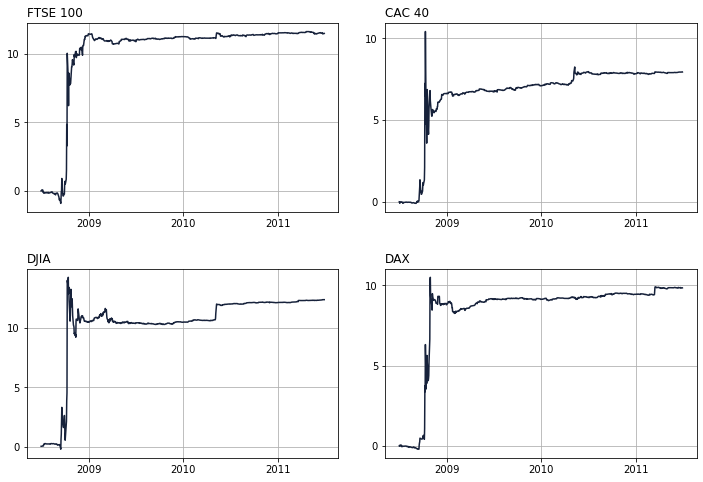

In [19]:
net_sse = (errors["HAR"]**2 - errors["HAR+SV"]**2).groupby(level=1).cumsum() * 10**4
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for i, index in enumerate(indices):
    xs = net_sse.xs(index, level=1)
    ax = axes[i] 
    ax.grid()
    ax.plot(xs.index, xs, c="#17223B")
    ax.set_title(index, loc="left")
    ax.xaxis.set_major_locator(mdates.YearLocator(1)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=5))
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()